# Behavioral Cloning Project

In this project, I will train a model to teach a car to drive in a track with no traffic.

The model will be trained using the data provided by Udacity.

## 1. Load the data

In [1]:
import pandas
import numpy as np

def load_data():
    # trim white spaces according to http://stackoverflow.com/a/33790933/1065981
    df = pandas.read_csv("driving_log.csv", delimiter=" *, *")
    return df

df = load_data()
print("Number of records: {:d}".format(len(df['steering'])))

Number of records: 8036


/home/carnd/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:6: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.


## 2. Visualize the data


/home/carnd/anaconda3/lib/python3.5/site-packages/numpy/lib/function_base.py:564: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  n = np.zeros(bins, ntype)
/home/carnd/anaconda3/lib/python3.5/site-packages/numpy/lib/function_base.py:611: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  n += np.bincount(indices, weights=tmp_w, minlength=bins).astype(ntype)


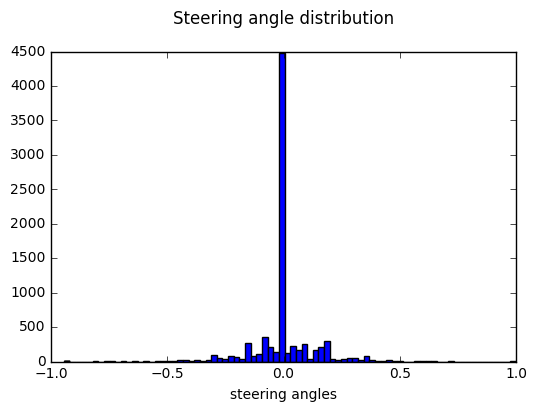

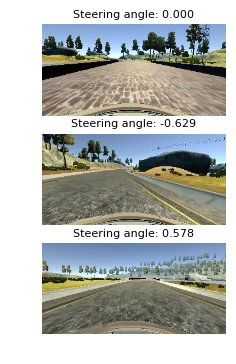

In [2]:
import matplotlib.pyplot as plt
# Visualizations will be shown in the notebook.
%matplotlib inline
import cv2

def draw_steering_histogram(steering_data, bin_width, positive_limit, subtitle=""):
    number_bins = 2 * positive_limit / bin_width
    plt.clf()
    plt.hist(steering_data, number_bins)
    plt.xlabel("steering angles")
    plt.title("Steering angle distribution\n" + subtitle)
    plt.show()
    
draw_steering_histogram(df['steering'], 0.05, 2.0)

def read_image(path):
    return cv2.imread(path)

def sub_plot(fig, path, angle, pos):
    a = fig.add_subplot(3, 1, pos) # 3 rows x 1 col
    plt.axis("off")
    plt.imshow(cv2.cvtColor(read_image(path), cv2.COLOR_BGR2RGB))
    a.set_title("Steering angle: {:.3f}".format(angle), fontsize = 8)

    # random images of left, straigh and right steering
fig = plt.figure()

images_drawn = [False, False, False] # Flags to check if image are displayed for center, left, and right
images_ready = False
for angle, path_center in zip(df['steering'], df['center']):
    if angle == 0 and images_drawn[0] is False:
        sub_plot(fig, path_center, angle, 1)
        images_drawn[0] = True
    elif angle < -0.5 and images_drawn[1] is False:
        sub_plot(fig, path_center, angle, 2)
        images_drawn[1] = True
    elif angle > 0.5 and images_drawn[2] is False:
        sub_plot(fig, path_center, angle, 3)
        images_drawn[2] = True
    images_ready = images_drawn[0] and images_drawn[1] and images_drawn[2]
    if images_ready is True:
        break


## 3. Balance the data

/home/carnd/anaconda3/lib/python3.5/site-packages/numpy/lib/function_base.py:564: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  n = np.zeros(bins, ntype)
/home/carnd/anaconda3/lib/python3.5/site-packages/numpy/lib/function_base.py:611: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  n += np.bincount(indices, weights=tmp_w, minlength=bins).astype(ntype)


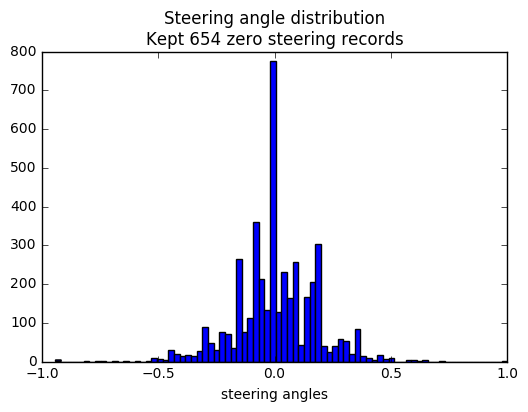

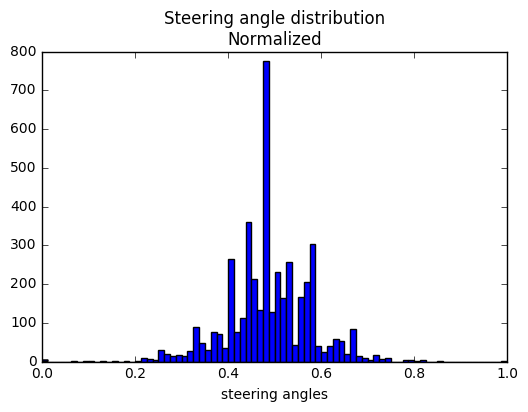

/home/carnd/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:58: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/carnd/anaconda3/lib/python3.5/site-packages/numpy/lib/function_base.py:564: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  n = np.zeros(bins, ntype)
/home/carnd/anaconda3/lib/python3.5/site-packages/numpy/lib/function_base.py:611: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  n += np.bincount(indices, weights=tmp_w, minlength=bins).astype(ntype)


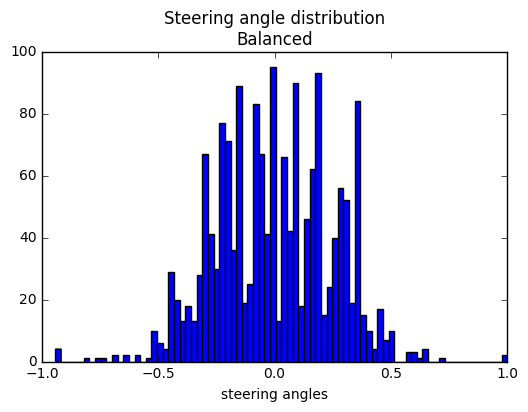

Number of records before balance: 8036
Number of records after balance: 1693


In [3]:
# cut off zero steering records
dataset = df.values
angles = dataset[:,3]
percetange_zero_drop = 85
zero_steering_records_to_keep = int(len(angles[angles == 0.0]) * (100-percetange_zero_drop)/100)

df_zeros = df.drop(df.index[df.steering != 0])
df_zeros = df_zeros.sample(zero_steering_records_to_keep)

df_non_zeros = df.drop(df.index[df.steering == 0])
df_zeros_reduced = pandas.concat([df_zeros, df_non_zeros])

draw_steering_histogram(df_zeros_reduced['steering'], 0.05, 2, "Kept {:d} zero steering records".format(zero_steering_records_to_keep))

# Remove negative angles
# df_pos = df_zeros_reduced.drop(df_zeros_reduced.index[df_zeros_reduced.steering < 0])
# df_balanced = pandas.DataFrame.copy(df_pos)

# Sort data frame by steering angle, ascending way
df_sorted = df_zeros_reduced.sort_values('steering', ascending = True)

# Normalize the angles between 0 and 1. 
def rescale(x, min_o, max_o, min_i, max_i):
    return ((x - min_i) * (max_o - min_o) / (max_i - min_i)) + min_o

angles = df_sorted.steering
max_i = np.max(angles) # max angle input
min_i = np.min(angles) # min angle input
max_o = 1.0 # max angle output
min_o = 0.0 # min angle output

df_normalized = pandas.DataFrame.copy(df_sorted)
df_normalized.steering = rescale(df_normalized.steering, min_o, max_o, min_i, max_i)
draw_steering_histogram(df_normalized['steering'], 0.05, 2, "Normalized")

# samples per number of bins
# if bin size is 20, then angles are group like
# [0.00 - 0.05], [0.05 - 0.10], [0.10 - 0.15], ..., [0.95 - 1.00]
bins_number = 40
hist = np.histogram(df_normalized.steering, bins_number)
average_per_bin = np.mean(hist[0])

# Remove samples in bins that exceeds the mean
column_names = df_normalized.columns.values
new_df = pandas.DataFrame(columns=column_names)

from sklearn.utils import shuffle

rows = df_normalized.values
low_limit, high_limit = 0, 0
for density, weight in zip(hist[0], hist[1]):
    low_limit = high_limit
    high_limit += density
    if low_limit != high_limit:
        current_bin = rows[low_limit: high_limit]
        if len(current_bin) > average_per_bin:
            current_bin = shuffle(current_bin) # Shuffle to avoid lossing the higher records in the bin
            current_bin =  current_bin[:average_per_bin]
            
        current_df = pandas.DataFrame(current_bin, columns=column_names)
        new_df = pandas.concat([new_df, current_df])
        
bins_number = 40
hist = np.histogram(new_df.steering, bins_number)
max_elements_in_bins = np.max(hist[0])
        
# Unnormalize data
df_balanced = pandas.DataFrame.copy(new_df)
df_balanced['steering'] = rescale(df_balanced['steering'], min_i, max_i, min_o, max_o)
draw_steering_histogram(df_balanced['steering'], 0.05, 2, "Balanced")

print("Number of records before balance: {:d}".format(len(df['steering'])))
print("Number of records after balance: {:d}".format(len(df_balanced['steering'])))

## 4. Split the data into training and validation sets

Records in train set: 1162
Records in test set: 531


/home/carnd/anaconda3/lib/python3.5/site-packages/numpy/lib/function_base.py:564: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  n = np.zeros(bins, ntype)
/home/carnd/anaconda3/lib/python3.5/site-packages/numpy/lib/function_base.py:611: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  n += np.bincount(indices, weights=tmp_w, minlength=bins).astype(ntype)


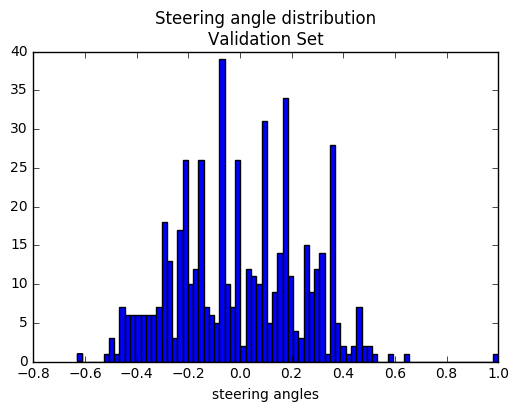

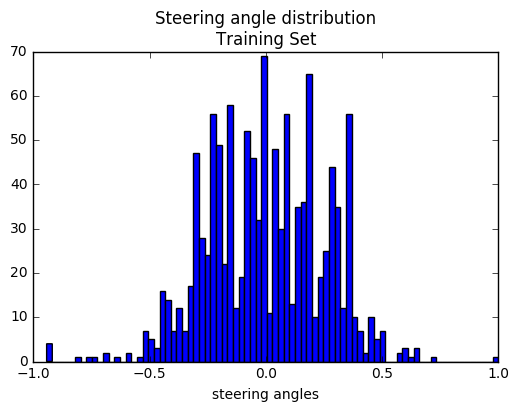

In [4]:
from sklearn.cross_validation import train_test_split

# Split data frame according to http://stackoverflow.com/a/24147363/1065981

mask = np.random.rand(len(df_balanced)) <= 0.3

train_df = df_balanced[~mask]
val_df = df_balanced[mask]

print("Records in train set: {:d}".format(len(train_df)))
print("Records in test set: {:d}".format(len(val_df)))

draw_steering_histogram(val_df['steering'], 0.05, 2, "Validation Set")
draw_steering_histogram(train_df['steering'], 0.05, 2, "Training Set")

def get_features_labels(df):
        
    # center, left, right, steering, throttle, brake, speed
    dataset = df.values
    
    X_center, X_left, X_right = dataset[:,0], dataset[:,1], dataset[:,2]
    y = dataset[:,3]

    assert len(X_center) == len(X_left) == len(X_right)== len(y)

    return X_center, X_left, X_right, y

X_val, X_val_left, X_val_right, y_val = get_features_labels(val_df)


## 5. Augment the data

Number of records before data augmentation: 1162
Number of records after data augmentation: 3486


/home/carnd/anaconda3/lib/python3.5/site-packages/numpy/lib/function_base.py:564: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  n = np.zeros(bins, ntype)
/home/carnd/anaconda3/lib/python3.5/site-packages/numpy/lib/function_base.py:611: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  n += np.bincount(indices, weights=tmp_w, minlength=bins).astype(ntype)


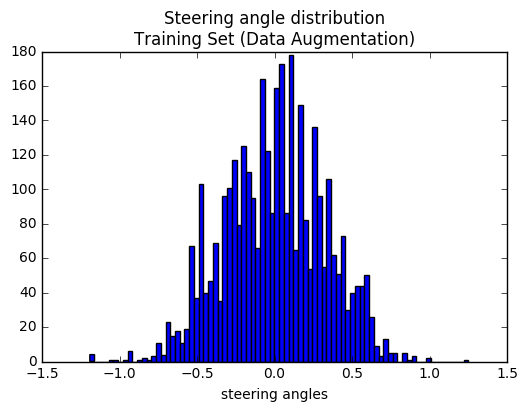

In [5]:
# Recovery threshold is defined to vary the steering
# angle of the side cameras as stated by Vivek Yadav
# here https://chatbotslife.com/using-augmentation-to-mimic-human-driving-496b569760a9#.ofn8g7j3g

recovery_threshold = 0.25
X_train_center, X_train_left, X_train_right, y_train_center = get_features_labels(train_df)

y_train_left = y_train_center + recovery_threshold
y_train_right = y_train_center - recovery_threshold

X_train = X_train_center
y_train = y_train_center

X_train = np.concatenate((X_train_center, X_train_left, X_train_right))
y_train = np.concatenate((y_train_center, y_train_left, y_train_right))

print("Number of records before data augmentation: {:d}".format(len(train_df['steering'])))
print("Number of records after data augmentation: {:d}".format(len(y_train)))
draw_steering_histogram(y_train, 0.05, 2, "Training Set (Data Augmentation)")

## 6. Define the architecture

In [6]:
from keras.models import Sequential
from keras.layers import Dense, Flatten, ELU, Activation, Lambda, Dropout
from keras.layers.convolutional import Convolution2D
from keras.optimizers import Adam

final_width = 200
final_height = 66
final_depth = 3
drop_out = .2
    
def get_model(learning):
        
    image_shape = (final_height, final_width, final_depth)

    print(image_shape)
    model = Sequential()
    model.add(Lambda(lambda x: x/127.5 - 1., input_shape=image_shape, output_shape=image_shape))
    
    model.add(Convolution2D(24, 5, 5, subsample=(2, 2), border_mode="valid"))
    model.add(Activation('relu'))
    #model.add(Dropout(drop_out))
    
    model.add(Convolution2D(36, 5, 5, subsample=(2, 2), border_mode="valid"))
    model.add(Activation('relu'))
    
    model.add(Convolution2D(48, 5, 5, subsample=(2, 2), border_mode="valid"))
    model.add(Activation('relu'))
    #model.add(Dropout(drop_out))
    
    model.add(Convolution2D(64, 3, 3, border_mode="valid"))
    model.add(Activation('relu'))
    
    model.add(Convolution2D(64, 3, 3, border_mode="valid"))
    #model.add(Dropout(drop_out))
    
    model.add(Flatten())
    model.add(Activation('relu'))

    model.add(Dense(100))
    model.add(Activation('relu'))

    model.add(Dense(50))
    model.add(Activation('relu'))
    #model.add(Dropout(.2))

    model.add(Dense(10))
    model.add(Activation('relu'))

    model.add(Dense(1))

    optimizer = Adam(lr=learning)
    model.compile(optimizer=optimizer, loss="mse")

    return model

Using TensorFlow backend.


## 7. Train Model

In [7]:
# Util functions to use in the generator

def read_image(path):
    return cv2.imread(path)

def flip_image(image):
    return cv2.flip(image, 1)

# As defined by Vivek Yadav
# https://chatbotslife.com/using-augmentation-to-mimic-human-driving-496b569760a9#.duh143vo1
def change_brightness(image):
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    hsv[:,:,2] = hsv[:,:,2] * (0.25 + np.random.uniform()) 
    return cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)

def crop_top_bottom(image, percentage_top, percentage_bottom):
    height = image.shape[0]
    crop_size_top = int(height * percentage_top / 100)
    crop_size_bottom = int(height * percentage_bottom / 100)
    return image[crop_size_top:height-crop_size_bottom,:,:]

def resize(image, width, height):
    return cv2.resize(image, (width, height), interpolation=cv2.INTER_CUBIC)

from random import randrange

def apply_augmentation(image, angle, flip_threshold):
    
    new_image = np.copy(image)
    new_angle = angle
    
    # Brightness
    ran = randrange(0, 3)
    
    if ran != 0:
        new_image = change_brightness(image)
    
    # Flip
    ran = randrange(0, 3)
    
    if ran != 0 and (angle <= - flip_threshold or angle >= flip_threshold):
        new_image = flip_image(new_image)
        new_angle *= -1
        
    # Angle distortion
    ran = randrange(0, 3)
    
    if ran != 0:
        factor = round(np.random.uniform(0.9, 1.1), 2)
        new_angle *= factor
    
    return new_image, new_angle

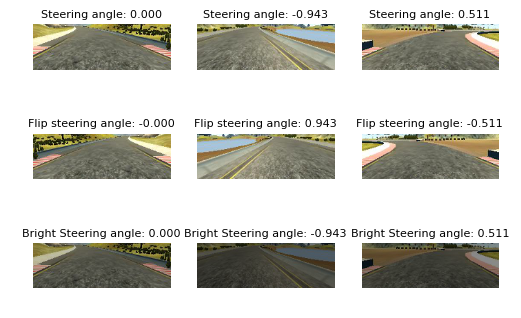

In [8]:
crop_top_percentage = 35
crop_bottom_percentage = 15
flip_threshold = 0.1

def sub_plot(fig, path, angle, pos):
    image = read_image(path)
    image = crop_top_bottom(image, crop_top_percentage, crop_bottom_percentage)
    image = resize(image, final_width, final_height)

    a = fig.add_subplot(3, 3, pos) # 3 rows x 1 col
    plt.axis("off")
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    a.set_title("Steering angle: {:.3f}".format(angle), fontsize = 8)
    
    a = fig.add_subplot(3, 3, pos + 3) # 3 rows x 1 col
    plt.axis("off")
    plt.imshow(cv2.cvtColor(flip_image(image), cv2.COLOR_BGR2RGB))
    a.set_title("Flip steering angle: {:.3f}".format(-angle), fontsize = 8)
    
    a = fig.add_subplot(3, 3, pos + 6) # 3 rows x 1 col
    plt.axis("off")
    plt.imshow(cv2.cvtColor(change_brightness(image), cv2.COLOR_BGR2RGB))
    a.set_title("Bright Steering angle: {:.3f}".format(angle), fontsize = 8)
    
fig = plt.figure()
images_drawn = [False, False, False] # Flags to check if image are displayed for center, left, and right
images_ready = False
for path, angle in zip(X_train, y_train):
    if angle == 0 and images_drawn[0] is False:
        sub_plot(fig, path, angle, 1)
        images_drawn[0] = True
    elif angle < -0.5 and images_drawn[1] is False:
        sub_plot(fig, path, angle, 2)
        images_drawn[1] = True
    elif angle > 0.5 and images_drawn[2] is False:
        sub_plot(fig, path, angle, 3)
        images_drawn[2] = True
    images_ready = images_drawn[0] and images_drawn[1] and images_drawn[2]
    if images_ready is True:
        break

In [9]:
def generator(Xpath, y, batch_size):

    total_input = len(Xpath)
    
    while True:
        features, targets = [], []
        i = 0
        while len(features) < batch_size:
            index = randrange(0, total_input)
            path = Xpath[index]
            
            angle = y[index]
            image = read_image(path)
            image = crop_top_bottom(image, crop_top_percentage, crop_bottom_percentage)
            image = resize(image, final_width, final_height)

            #image, ang = apply_augmentation(image, angle, flip_threshold)
            features.append(image)
            targets.append(angle)
            
        yield (np.array(features), np.array(targets))

In [10]:
def plot_metrics(history):
    keys = history.history.keys()

    for k in keys:
        plt.clf()
        plt.plot(history.history[k])
        plt.title("model " + k)
        plt.ylabel(k)
        plt.xlabel('epoch')
        plt.show()

In [11]:
def getFeaturesTargets(Xpath, y):
    feats = []
    targets = []
    for path, angle in zip(Xpath, y):
        image = read_image(path)
        image = crop_top_bottom(image, 35, 15)
        image = resize(image, final_width, final_height)
        feats.append(image)
        targets.append(angle)

    return np.array(feats), np.array(targets)

(66, 200, 3)
Epoch 1/13
3200/3200 [==============================] - 10s - loss: 0.1009 - val_loss: 0.0591
Epoch 2/13
3200/3200 [==============================] - 2s - loss: 0.1005 - val_loss: 0.0439
Epoch 3/13
3200/3200 [==============================] - 2s - loss: 0.0890 - val_loss: 0.0462
Epoch 4/13
3200/3200 [==============================] - 3s - loss: 0.0669 - val_loss: 0.0436
Epoch 5/13
3200/3200 [==============================] - 4s - loss: 0.0751 - val_loss: 0.0393
Epoch 6/13
3200/3200 [==============================] - 4s - loss: 0.0632 - val_loss: 0.0308
Epoch 7/13
3200/3200 [==============================] - 4s - loss: 0.0518 - val_loss: 0.0489
Epoch 8/13
3200/3200 [==============================] - 4s - loss: 0.0471 - val_loss: 0.0273
Epoch 9/13
3200/3200 [==============================] - 4s - loss: 0.0434 - val_loss: 0.0285
Epoch 10/13
3200/3200 [==============================] - 4s - loss: 0.0441 - val_loss: 0.0270
Epoch 11/13
3200/3200 [==============================] 

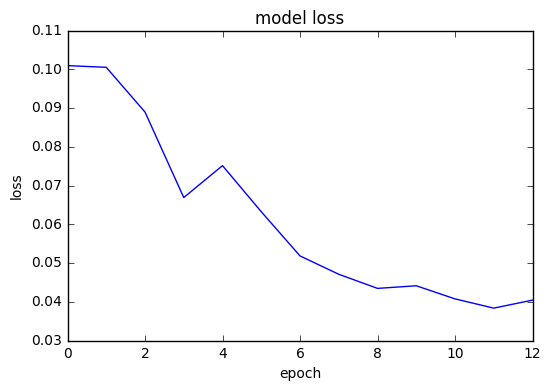

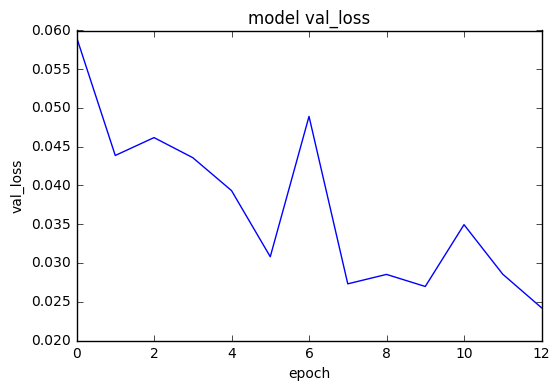

In [17]:
import json

learning_rate = 0.001
training_size = 3200
batch_size = 1600
epochs = 13

model = get_model(learning_rate)

history =  model.fit_generator(
        generator(X_train, y_train, batch_size),
        samples_per_epoch = training_size,
        validation_data = getFeaturesTargets(X_val, y_val),
        nb_epoch = epochs
    )

plot_metrics(history)

model.save_weights("model.h5")
with open("model.json", "w+") as outfile:
    json.dump(model.to_json(), outfile)